In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '337627',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 26)
page number = 20 (max: 100, len: 17)
page number = 30 (max: 100, len: 12)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (97053, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,337627,BGFreakDag2PT,N/A,On Radar
1,337627,Bstalf21,N/A,KS fall?
2,337627,bucklen_uk,N/A,I don't rate my own games (doesn't seem approp...
3,337627,carlcorey,N/A,"Turczi / Mindclash with O'Toole design, intere..."
4,337627,Dahanil,N/A,David Turczi + Ian O'Toole - tasty combination!
...,...,...,...,...
97048,167791,z_zadar,9,Some games are so much fun. Others can be a li...
97049,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
97050,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
97051,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 16585 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         15088
9          14957
8          13317
7           7371
N/A         6711
           ...  
6.08667        1
9.013          1
5.54           1
7.73           1
7.68           1
Name: rating, Length: 545, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(73757, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6711, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"I hoped for something much better, but still really enjoyed it. It didn't live up to the hype, but it's still a solid 8. Might go up once I play with the other ingredient sets.  After 2 more plays, I get the feeling this game is something special. It is extremely exciting and funny at the same time and even though it is very luck-dependent, it does make you think about what you want to have in your bag in order to trigger the best combos of chip powers.  A joy to play - Wolfgang Warsch is a really special designer. If only the game looked nice!  After having played the game around 30 times, I must say that it can get repetitive. I am still enjoying it, but ultimately traded it away. Happy to play anytime, though, if somebody offered."

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Dice Tower Cruise 2019'

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [33]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.8085315 ,  0.32554334,  0.05144133,  0.66053295, -0.06461677,
        -0.03124241,  0.32588527,  0.16024171, -0.6984755 ,  0.6324691 ,
         0.18296473,  0.2533136 ,  0.09586978,  0.02829212, -0.30635536,
        -0.22998805, -0.62423086,  0.1340422 ,  0.37968037, -0.91938823,
         0.02340381, -0.3798724 ,  0.66412205,  0.22965968, -0.22774836,
         0.34139758, -1.1359853 ,  0.16717103,  0.21839228, -0.36914703,
        -0.35738912,  0.16831025,  0.5269951 , -0.3284274 , -0.2515757 ,
         0.5047349 ,  0.17656086, -0.12429959,  0.45823887, -0.93502337,
         0.02979618,  0.2649761 , -0.05524481,  0.19430737, -0.26541945,
         0.27014336, -0.5552477 , -0.70117176,  0.16074596,  0.15508507],
       [ 0.73094535,  0.09834008, -0.10046062,  0.8907449 , -0.04812922,
         0.02977946,  0.19393201, -0.1920169 , -0.4437387 ,  0.32995826,
         0.2695139 ,  0.48733565,  0.2047014 ,  0.14074436, -0.2101692 ,
 

In [34]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [36]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
109/109 - 8s - loss: 0.4963 - accuracy: 0.8349 - val_loss: 0.3888 - val_accuracy: 0.8527
Epoch 2/40
109/109 - 5s - loss: 0.3339 - accuracy: 0.8638 - val_loss: 0.3183 - val_accuracy: 0.8754
Epoch 3/40
109/109 - 5s - loss: 0.2724 - accuracy: 0.8917 - val_loss: 0.3055 - val_accuracy: 0.8811
Epoch 4/40
109/109 - 5s - loss: 0.2356 - accuracy: 0.9075 - val_loss: 0.3072 - val_accuracy: 0.8785
Epoch 5/40
109/109 - 5s - loss: 0.2092 - accuracy: 0.9188 - val_loss: 0.3189 - val_accuracy: 0.8756
Epoch 6/40
109/109 - 5s - loss: 0.1893 - accuracy: 0.9271 - val_loss: 0.3350 - val_accuracy: 0.8736
Epoch 7/40
109/109 - 5s - loss: 0.1721 - accuracy: 0.9357 - val_loss: 0.3554 - val_accuracy: 0.8696
Epoch 8/40
109/109 - 5s - loss: 0.1586 - accuracy: 0.9415 - val_loss: 0.3751 - val_accuracy: 0.8656


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [39]:
epochs = range(1, len(acc) + 1) 

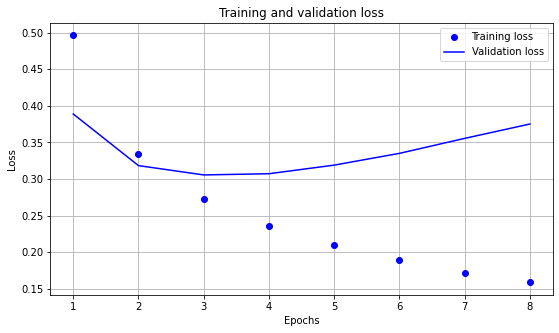

In [40]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

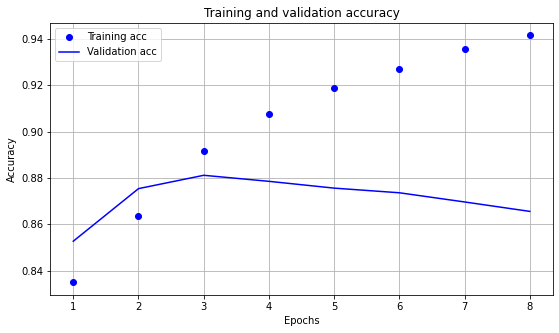

In [41]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [43]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Con muchas posibilidades"
score: 0.991926
actual value:1

input:
"It's like playing spades, but everyone is your partner. Adjustable level of difficulty with missions, each round is maybe 15 minutes, perfect for people who aren't gamers, plays 3-5 players and they all work. Haven't played 2-player yet."
score: 0.997586
actual value:1

input:
"One of the types of games with very simple rules, but a lot of strategy to employ. I got burnt out on it somewhat quickly, but my wife loves this game and would probably give it an 8 or 9, so I increased my rating to a 7."
score: 0.999358
actual value:1

input:
"1-5, 4"
score: 0.602923
actual value:0

input:
"Takes a few games to really pick up whats happening, but even those first few are great."
score: 0.982517
actual value:1

input:
"Nordstrand"
score: 0.990497
actual value:1

input:
"gameplay is very heavy for beginners, artwork is good, I adore the theme (mankind = disease) - perfect! nature vs. invasors - wood vs. plastic - ironicall

In [44]:
## APPLY MODEL ON NON-RATED COMMENTS

In [45]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"spiel des jahres 2018 winner, BGG: #37 overall, #1 abstract, #1 family (March 2019), overlays: "
score: 0.998282

input:
"I like this game more and more each time I play it. Solo game works well too, have yet to beat it though. Wish component quality was better"
score: 0.999302

input:
"All in pledge level, plus a few minor add ons. Delivery in two waves (Dec 2019), and (May 2020)."
score: 0.998251

input:
"This is a very good game... only not for my taste. Problem, as almost always in cooperatives, is too tactic play. It has strategy, but tactical warfare is so hypnotic that it is worst that I though learning to play it. I feel a bit lazy when thinking in playing it.  On the other hand, design is very good, powers can be combined between spirits for real cooperation. It is exciting and very tight, so you can enjoy it for many matches. Very replayable."
score: 0.846905

input:
"Only going to trade this for something *really good Sundrop Core + Sundrop stretch goals + Echoes of 

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [86]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.35 |           3491 |
| 167355 |          8.42 |           1780 |
| 167791 |          8.21 |           8206 |
| 169427 |          8.60 |            214 |
| 169786 |          8.10 |           7316 |


In [48]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [87]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.66 |            309 |
| 167355 |          8.86 |            212 |
| 167791 |          8.87 |            437 |
| 169427 |          8.87 |             72 |
| 169786 |          8.70 |            588 |


In [66]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [82]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.060000,8.383333,1,2022
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.917436,9.183333,8.034125,2,2020
2,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.114639,8.470833,8.150761,3,2020
3,"<img src=""https://cf.geekdo-images.com/eUiju5S...","<a href=""https://boardgamegeek.com/boardgame/3...",8.583333,9.120000,8.775000,4,2021
4,"<img src=""https://cf.geekdo-images.com/-JD8JLn...","<a href=""https://boardgamegeek.com/boardgame/2...",8.429787,9.252381,8.817978,5,2021


In [68]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [69]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.060000,8.383333,1,2022
2,,Lost Ruins of Arnak,7.917436,9.183333,8.034125,2,2020
3,,Dune: Imperium,8.114639,8.470833,8.150761,3,2020
4,,Stationfall,8.583333,9.120000,8.775000,4,2021
5,,Merchants Cove,8.429787,9.252381,8.817978,5,2021


In [70]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.060000,8.383333,1,2022
2,,Chronicles of Drunagor: Age of Darkness,9.462963,8.845455,9.284211,20,2021
3,,Eclipse: Second Dawn for the Galaxy,8.741260,8.828916,8.755332,37,2020
4,,Brass: Birmingham,8.688985,8.949784,8.713151,24,2018
5,,Gloomhaven: Jaws of the Lion,8.619705,8.476515,8.605255,22,2020


In [71]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.462963,8.845455,9.284211,20,2021
2,,Merchants Cove,8.429787,9.252381,8.817978,5,2021
3,,Stationfall,8.583333,9.120000,8.775000,4,2021
4,,Eclipse: Second Dawn for the Galaxy,8.741260,8.828916,8.755332,37,2020
5,,Brass: Birmingham,8.688985,8.949784,8.713151,24,2018


In [61]:
# model.save('saved_model\my_model')

In [62]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [63]:
# some examples on "long" comments vs short comments

In [72]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Condition:    NIS (New In Shrink) Acquisition:  8/28/2020 Source:       GameNerdz MSRP:         $59.99 Paid Price:   $34.99  + Custom Box Insert"
score: 0.998726

input:
":d6-1: Seems like a great game but it is very expensive and takes a lot more time than I have available at the moment."
score: 0.562522

input:
"Missed the first Kickstarter and after seeing the plethora of high reviews and the rave comments I couldn't miss out the second time.  Kickstarted."
score: 0.929825

input:
"Looks very interesting. Can I get the rewarding gameplay of Gloomhaven without the massive box? If so then this might replace the original. Then again, if they ever implemented the map system used in this game as part of the original, that might help me get it to the table a lot more often."
score: 0.937960

input:
"I have played Gloomhaven a nunmber of times with a friend (his copy), and think that this smaller version may be fun for me and my husband to play."
score: 0.688007

input:
"Played thi